In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
from IPython.display import clear_output

import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
exp = JetFindingExperiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/1"))
ds = exp.ds
all_jets_one_df, all_jets_over_time, flags = exp.track_jets()
props_as_df_uncat = exp.props_as_df(False)
props_as_df = exp.props_as_df(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_df_uncat)
ds = exp.ds
da = exp.ds["s"]
props_as_df = get_nao(props_as_df)
jet_pos_da = jet_position_as_da(all_jets_one_df)
# props_as_df = get_double_jet_index(props_as_df, jet_pos_da)
props_as_df_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8]))

In [3]:
metric = "euclidean"
nx = 6
ny = 4
exp_s = Experiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/4"))

ds_center_path = exp_s.path.joinpath(f"som_{nx}_{ny}_pbc_{metric}_center.nc")
if not ds_center_path.is_file():
    ds = exp.ds
    ds = ds.sel(time=ds.time.dt.season=="JJA")
net, centers, labels = exp_s.som_cluster(
    nx,
    ny,
    activation_distance=metric,
    return_type=RAW_REALSPACE,
    force=False,
    sigma=2,
    train_kwargs=dict(num_epochs=20),
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
if not ds_center_path.is_file():
    ds_center = labels_to_centers(labels, ds)
    ds_center.to_netcdf(ds_center_path)
else:
    ds_center = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_s.da.time, "cluster": np.arange(net.n_nodes)})

# sweep sizes again

In [56]:
from sklearn.metrics import calinski_harabasz_score
from jetstream_hugo.definitions import compute
nys = [2, 3, 4, 5, 6, 7, 8]
dys = [0, 2, 4]
# nxs = [6]
# dxs = [-2]
quant_errors = {}
topo_errors = {}
ch_indices = {}
projections = {}
X, da_weighted = exp_s.prepare_for_clustering()
da_weighted = coarsen_da(da_weighted, 1.5)
X = da_weighted.data.reshape(exp_s.data_handler.get_flat_shape()[0], -1)
X, meanX, stX = normalize(X)
X = compute(X, progress=True)
for ny in nys:
    for dy in dys:
        nx = ny + dy
        net, centers, labels = exp_s.som_cluster(
            nx,
            ny,
            activation_distance="euclidean",
            return_type=RAW_REALSPACE,
            force=False,
            init="pca",
            sigmaN=0.1,
            train_kwargs=dict(num_epochs=20),
        )
        quant_errors[(nx, ny)] = net.quantization_error(X)
        topo_errors[(nx, ny)] = net.topographic_error(X)
        ch_indices[(nx, ny)] = calinski_harabasz_score(X, labels)
        projections[(nx, ny)] = np.quantile((net.weights[labels] * X).sum(axis=1) / np.linalg.norm(net.weights, axis=1)[labels] / np.linalg.norm(X, axis=1), q=0.05)

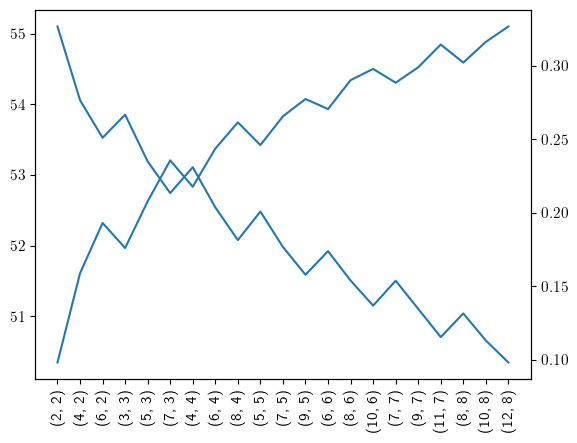

In [62]:
fig, ax = plt.subplots()
twin1 = ax.twinx()
# twin2 = ax.twinx()
# twin2.spines.right.set_position(("axes", 1.12))
ax.plot(quant_errors.values())
# twin1.plot(ch_indices.values())
twin1.plot(projections.values())
keys = list(ch_indices)
ax.set_xticks(np.arange(len(keys)), keys, ha="center")
ax.tick_params(axis='x', labelrotation=90)

# Presentation plots

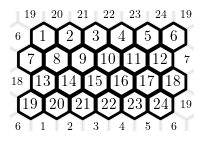

In [4]:
from matplotlib.colors import LinearSegmentedColormap
from xpysom_dask import plots as splots
from xpysom_dask.neighborhoods import Neighborhoods
outer_grid, inner_grid, coords, outermask = splots.create_outer_grid(6, 4)
nei = Neighborhoods(6, 4, "hexagons", PBC=True)
cmap = colormaps.cet_l_bmw
cmap = LinearSegmentedColormap.from_list("hoho", cmap(np.linspace(0.45, 1.0, cmap.N // 2)))
from_ = 5
# distances = nei.distances[from_, outer_grid]
distances = np.full(len(coords), np.nan)
edgecolors = np.full(len(coords), 'black', dtype=object)
edgecolors[outermask] = 'gray'
alphas = np.ones(len(coords))
alphas[outermask] = 0.05
fig, ax = splots.plot_map(
    coords, distances, 'hexagons', 
    draw_cbar=False, figsize=(0.5 * TEXTWIDTH_IN, 1.55), 
    show=False, edgecolors = 'black', cmap=None,
    alphas=alphas, linewidths=2,
)
xlims = [np.amin(coords[~outermask][:, 0]) - 0.8, np.amax(coords[~outermask][:, 0]) + 0.8]
ylims = [np.amin(coords[~outermask][:, 1]) - 1, np.amax(coords[~outermask][:, 1]) + 1]
for i, c in enumerate(coords):
    x, y = c
    # textcolor = "white" if distances[i] < 2 else "black"
    fontsize = 8 if outermask[i] else 11
    if x > xlims[0] and x < xlims[-1] and y > ylims[0] and y < ylims[-1]: 
        ax.text(x, y, f'${outer_grid.flatten()[i] + 1}$', va='center', ha='center', color="black", fontsize=fontsize)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_aspect("equal")
# ax.set_title(f"Distance to cluster {to_prettier_order(from_)}", pad=5)
plt.savefig(f"{FIGURES}/som_demo/som_numbering.png")

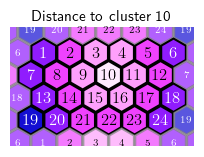

In [5]:
from matplotlib.colors import LinearSegmentedColormap
from xpysom_dask import plots as splots
from xpysom_dask.neighborhoods import Neighborhoods
outer_grid, inner_grid, coords, outermask = splots.create_outer_grid(6, 4)
nei = Neighborhoods(6, 4, "hexagons", PBC=True)
cmap = colormaps.cet_l_bmw_r
cmap = LinearSegmentedColormap.from_list("hoho", cmap(np.linspace(0.0, 0.75, cmap.N // 2)))
from_ = 9
distances = nei.distances[from_, outer_grid]
# distances = np.full(len(coords), np.nan)
edgecolors = np.full(len(coords), "black", dtype=object)
edgecolors[outermask] = 'gray'
alphas = np.ones(len(coords))
alphas[outermask] = 0.7
fig, ax = splots.plot_map(
    coords, distances, 'hexagons', 
    draw_cbar=False, figsize=(0.5 * TEXTWIDTH_IN, 1.55), 
    show=False, edgecolors = edgecolors, cmap=cmap,
    alphas=alphas, linewidths=1.5,
)
xlims = [np.amin(coords[~outermask][:, 0]) - 0.8, np.amax(coords[~outermask][:, 0]) + 0.8]
ylims = [np.amin(coords[~outermask][:, 1]) - 1, np.amax(coords[~outermask][:, 1]) + 1]
for i, c in enumerate(coords):
    x, y = c
    textcolor = "white" if distances[i] > 2 else "black"
    fontsize = 7 if outermask[i] else 12
    if x > xlims[0] and x < xlims[-1] and y > ylims[0] and y < ylims[-1]: 
        ax.text(x, y, f'${outer_grid.flatten()[i] + 1}$', va='center', ha='center', color=textcolor, fontsize=fontsize)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_aspect("equal")
ax.set_title(f"Distance to cluster {from_ + 1}", pad=5)
plt.savefig(f"{FIGURES}/som_demo/som_distances.png")

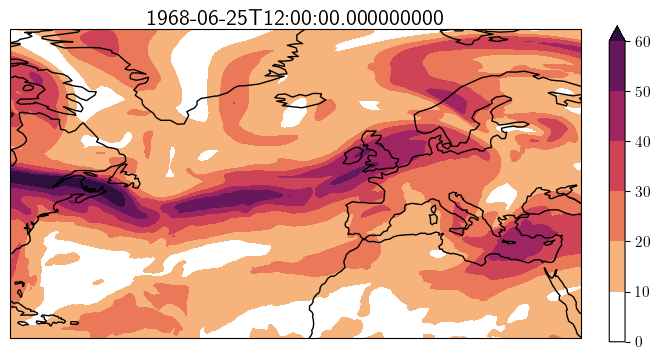

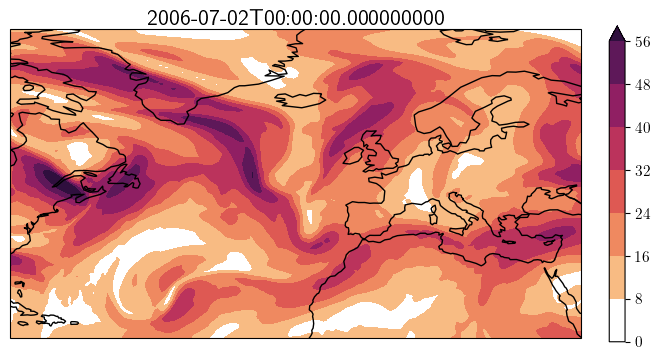

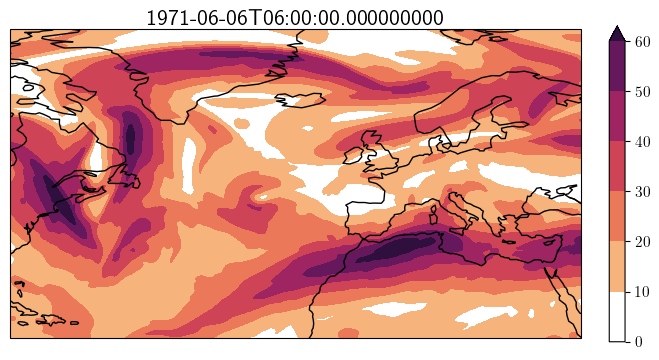

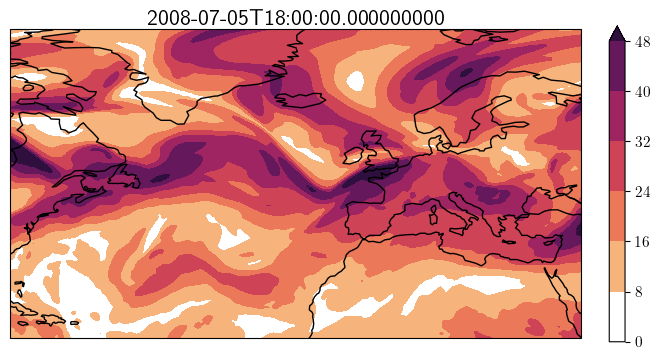

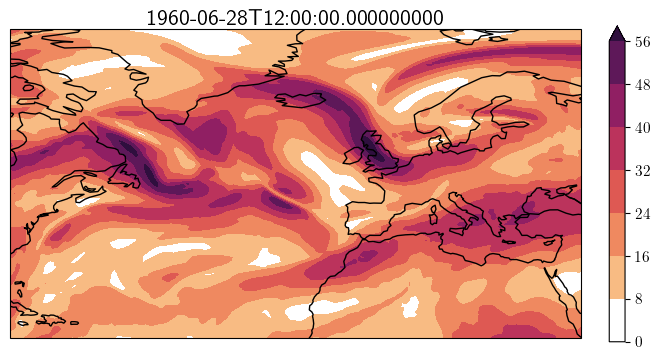

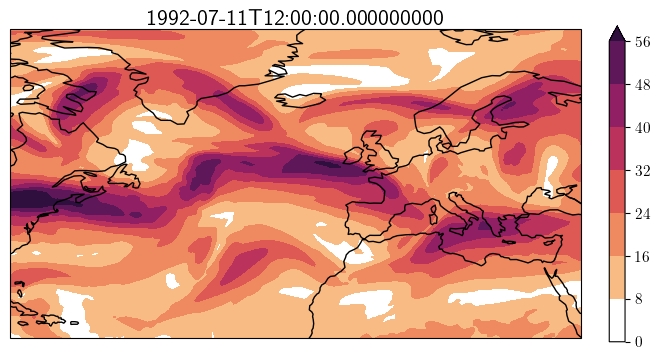

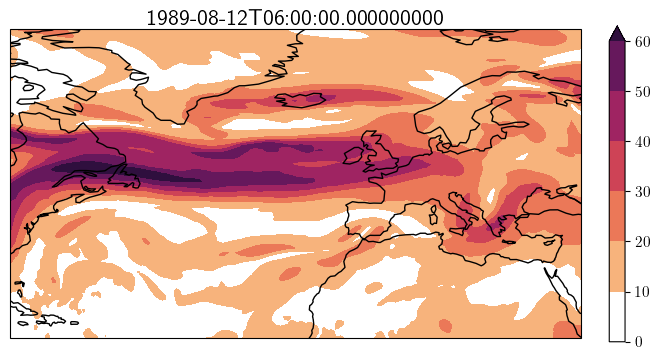

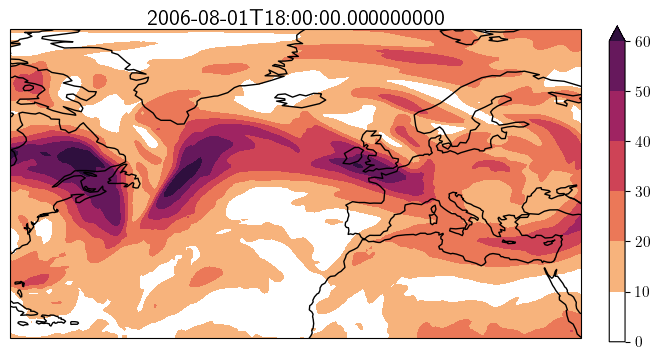

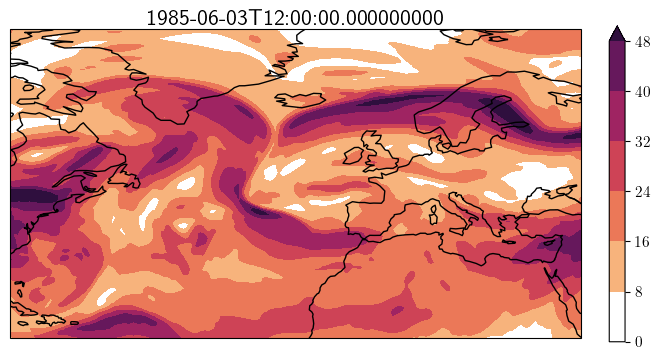

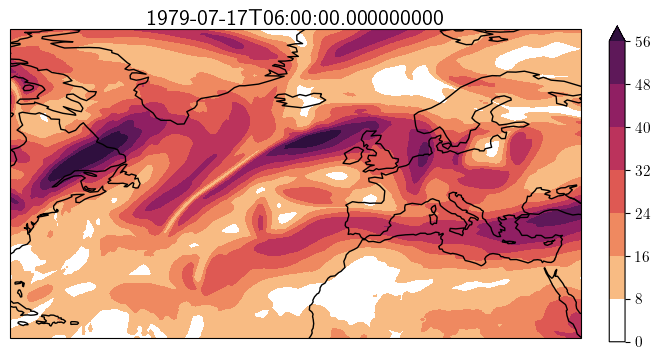

In [7]:
rng = np.random.default_rng()
da = exp_s.da
indices = rng.integers(da.shape[0], size=10)
clu = None
for ind in indices:
    clu = Clusterplot(1, 1, get_region(da))
    to_plot = da.isel(time=ind)
    _ = clu.add_contourf([to_plot], levels=7, cmap=colormaps.matter, titles=[da.time[ind].values], draw_cbar=True, transparify=1)
    plt.savefig(f"{FIGURES}/som_demo/{ind}.png")
    del clu
    clear_output()

/scratch/local/11611211/ipykernel_1807965/1511452564.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  period = pd.date_range("20120810", "20120831", freq="6H")


(<Figure size 840x400 with 2 Axes>, <Axes: >)

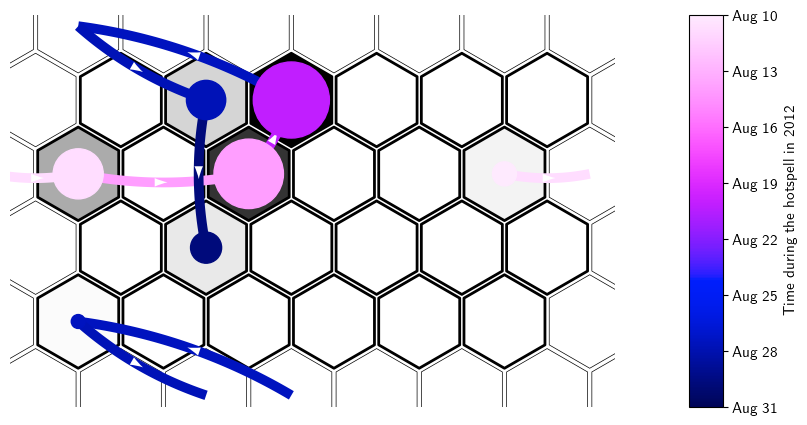

In [5]:
from matplotlib.colors import LinearSegmentedColormap
from xpysom_dask import plots as splots
from xpysom_dask.neighborhoods import Neighborhoods
period = pd.date_range("20120810", "20120831", freq="6H")
splots.plt_traj_hotspell(6, 4, period, labels)
# plt.savefig(f"{FIGURES}/som_demo/traj_pers.png")

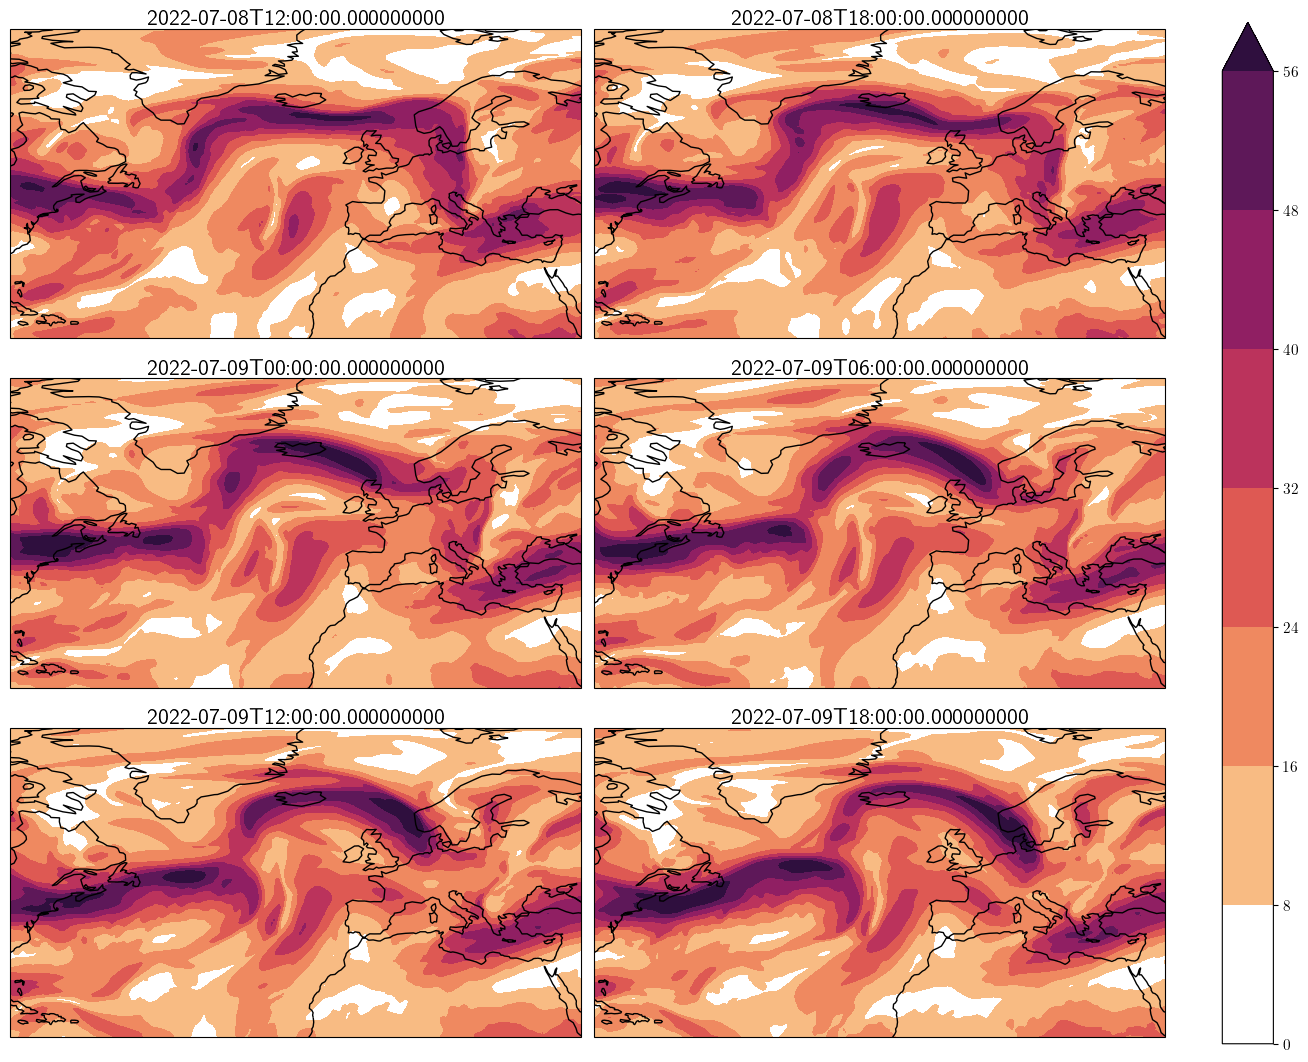

In [9]:
clu = Clusterplot(3, 2, get_region(da))
i = 23337 - 3
is_ = np.arange(i, i + 6)
_ = clu.add_contourf(da[is_], titles=da.time[is_].values, levels=7, cmap=colormaps.matter, transparify=1)
plt.savefig(f"{FIGURES}/som_demo/maps.png")

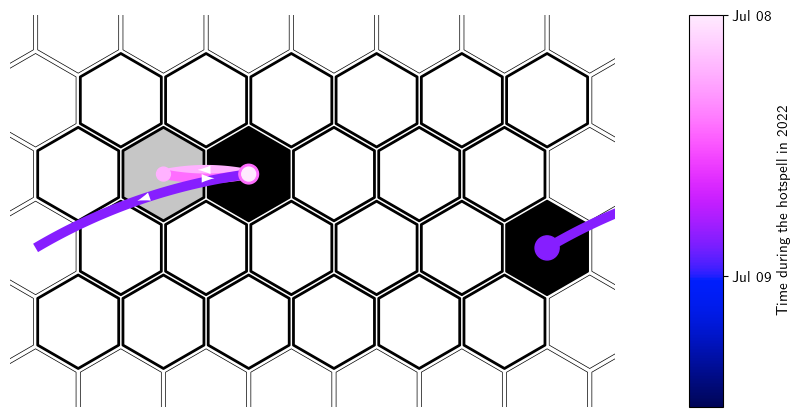

In [10]:
period = TIMERANGE[np.isin(TIMERANGE.month, [6, 7, 8])][23337 - 3:23337 + 4]
splots.plt_traj_hotspell(6, 4, period, labels)
plt.savefig(f"{FIGURES}/som_demo/traj.png")

In [63]:
pairwise_ = net.neighborhoods.distances[labels[:-1], labels[1:]]
np.where(pairwise_ > 3)[0]

array([ 1471,  2695,  3096,  3097,  3822,  3823,  4528, 14679, 17295,
       19135, 19960, 22815, 23337])

# Main plots

## Sammon Map

In [33]:
from sklearn.metrics import pairwise_distances
from numba import jit, prange
import numpy as np
from sklearn.decomposition import PCA


@jit
def distance(x1: float, x2: float, y1: float, y2: float) -> float:
    dx = x2 - x1
    # if np.abs(dx) > 180:
    #     dx = 360 - np.abs(dx)  # sign is irrelevant
    dy = y2 - y1
    return np.sqrt(dx**2 + dy**2)


@jit(parallel=False)
def my_pairwise(X1: np.ndarray, X2: np.ndarray | None = None) -> np.ndarray:
    x1 = X1[:, 0]
    y1 = X1[:, 1]
    half = False
    if X2 is None:
        X2 = X1
        half = True
    x2 = X2[:, 0]
    y2 = X2[:, 1]
    output = np.zeros((len(X1), len(X2)))
    for i in prange(X1.shape[0] - int(half)):
        if half:
            for j in range(i + 1, X1.shape[0]):
                output[i, j] = distance(x1[j], x2[i], y1[j], y2[i])
                output[j, i] = output[i, j]
        else:
            for j in range(X2.shape[0]):
                output[i, j] = distance(x1[j], x2[i], y1[j], y2[i])
    return output

@jit
def sammon_loop(
    y: np.ndarray, 
    D: np.ndarray,
    n: int, 
    N: int,
    display: int=2,
    inputdist="raw",
    maxhalves=20,
    maxiter=500,
    tolfun=1e-9,
):
    scale = 0.5 / D.sum()
    D = D + np.eye(N)

    Dinv = 1 / D
    one = np.ones((N, n))
    d = my_pairwise(y) + np.eye(N)
    dinv = 1.0 / d
    delta = D - d
    E = ((delta**2) * Dinv).sum()

    # Get on with it
    for i in range(maxiter):

        # Compute gradient, Hessian and search direction (note it is actually
        # 1/4 of the gradient and Hessian, but the step size is just the ratio
        # of the gradient and the diagonal of the Hessian so it doesn't
        # matter).
        delta = dinv - Dinv
        deltaone = np.dot(delta, one)
        g = np.dot(delta, y) - (y * deltaone)
        dinv3 = dinv**3
        y2 = y**2
        H = (
            np.dot(dinv3, y2)
            - deltaone
            - 2 * y * np.dot(dinv3, y)
            + y2 * np.dot(dinv3, one)
        )
        s = -g.T.flatten() / np.abs(H.T.flatten())
        y_old = y

        # Use step-halving procedure to ensure progress is made
        for j in range(maxhalves):
            s_reshape = np.reshape(s, (n, -1)).T
            y = y_old + s_reshape
            d = my_pairwise(y) + np.eye(N)
            dinv = 1 / d
            delta = D - d
            E_new = ((delta**2) * Dinv).sum()
            if E_new < E:
                break
            else:
                s = 0.5 * s

        # Bomb out if too many halving steps are required
        # if j == maxhalves - 1:
        #     print("Warning: maxhalves exceeded. Sammon mapping may not converge...")

        # Evaluate termination criterion
        if abs((E - E_new) / E) < tolfun:
            # if display:
            #     print("TolFun exceeded: Optimisation terminated")
            break

        # Report progress
        E = E_new
        # if display > 1:
        #     print("epoch = %d : E = %12.10f" % (i + 1, E * scale))

    # if i == maxiter - 1:
    #     print("Warning: maxiter exceeded. Sammon mapping may not have converged...")

    # Fiddle stress to match the original Sammon paper
    E = E * scale

    return y, E


def sammon(
    x,
    n,
    yinit: np.ndarray | None = None,
    display=2,
    inputdist="raw",
    maxhalves=20,
    maxiter=500,
    tolfun=1e-9,
    init="default",
):
    if inputdist == "distance":
        D = x
    else:
        D = pairwise_distances(x, n_jobs=10)
        if init == "default":
            init = "pca"

    if inputdist == "distance" and init == "pca":
        raise ValueError("Cannot use init == 'pca' when inputdist == 'distance'")

    if np.count_nonzero(np.diagonal(D)) > 0:
        raise ValueError("The diagonal of the dissimilarity matrix must be zero")

    N = x.shape[0]
    if yinit is None:
        if init == "pca":
            y = PCA(n).fit_transform(x)
        else:
            y = np.random.normal(0.0, 1.0, [N, n])

    # Remaining initialisation
    return sammon_loop(y, D, n, N, display, maxhalves, maxiter, tolfun)

In [4]:
X, da_weighted = exp_s.prepare_for_clustering()
da_weighted = coarsen_da(da_weighted, 1.5)
X = da_weighted.data.reshape(exp_s.data_handler.get_flat_shape()[0], -1)
X, meanX, stX = normalize(X)
X = compute(X, progress_flag=True)

In [5]:
import polars_ds as pds
X_df = pl.DataFrame(X)
expr = pds.principal_components(*[pl.col(f"column_{i}") for i in range(X.shape[1])], k=2, center=False)
pca = X_df.select(expr)
y = pca.unnest("literal").to_numpy()

In [36]:
y = pca.unnest("literal").cast({f"pc{i}": pl.Float32 for i in range(1, 3)})
y = y.with_row_index()

In [37]:
pairwise = y.lazy().join(y.lazy(), how="cross")
pairwise = pairwise.filter(pl.col("index") < pl.col("index_right"))
pairwise = pairwise.select(((pl.col("pc1") - pl.col("pc1_right")).pow(2) + (pl.col("pc2") - pl.col("pc2_right")).pow(2)).sqrt(), pl.col("index"), pl.col("index_right"))

In [38]:
pairwise.collect()

pc1,index,index_right
f32,u32,u32
1.347167,0,1
3.058528,0,2
2.450591,0,3
2.757022,0,4
1.093004,0,5
…,…,…
1.473824,23548,23550
0.906823,23548,23551
1.226401,23549,23550


In [ ]:
y.join(y, how="cross")

In [29]:
D = my_pairwise(X)

In [65]:
sammon_loop(y, D, 2, X.shape[0], maxiter=2)

(array([[ 0.80399, -0.00882],
        [ 0.63362, -0.10896],
        [ 0.8565 , -0.52079],
        ...,
        [ 1.83745, -0.8342 ],
        [ 2.16834, -0.26368],
        [ 1.71558, -0.96533]]),
 0.11878096047113033)

In [62]:
%lprun -f sammon_loop sammon_loop(y, D, 2, X.shape[0], maxiter=2)

Timer unit: 1e-09 s

Total time: 178.449 s
File: /scratch/local/10971599/ipykernel_2952947/2993765535.py
Function: sammon_loop at line 38

Line #      Hits         Time  Per Hit   % Time  Line Contents
    38                                           def sammon_loop(
    39                                               y: np.ndarray, 
    40                                               D: np.ndarray,
    41                                               n: int, 
    42                                               N: int,
    43                                               display: int=2,
    44                                               inputdist="raw",
    45                                               maxhalves=20,
    46                                               maxiter=500,
    47                                               tolfun=1e-9,
    48                                           ):
    49         1  283591753.0    3e+08      0.2      scale = 0.5 / D.sum()
    50 

## Link to summer wrs

In [4]:
dh = DataHandler.from_specs("ERA5", "plev", "z", "6H", "all", "JJA", -80, 40, 15, 80, 500, "dayofyear", {"dayofyear": ("win", 90)}, None)
exp_z = Experiment(dh)
centers_z, labels_z = exp_z.do_kmeans(4, 30, weigh_grams=False)

100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


In [12]:
coslat = np.cos(np.deg2rad(centers_z.lat))
Pwr = (exp_z.da * centers_z * coslat).sum(["lon", "lat"]) / coslat.sum() / centers_z.lon.shape[0]
Iwr = (Pwr - Pwr.mean("time")) / Pwr.std("time", ddof=0)
Iwr = compute(Iwr)
Iwr = xarray_to_polars(Iwr.rename("Iwr")).drop("ratio", "label")

In [129]:
# Iwr = Iwr.with_columns(year=pl.col("time").dt.year())
sigma_wr = Iwr["Iwr"].std()
winner = Iwr.group_by("time", maintain_order=True).agg(pl.col("Iwr").arg_max().alias("winner"), pl.col("Iwr").max(), pl.col("year").first())
winner = winner.with_columns(winner=pl.when(pl.col("Iwr") > sigma_wr).then(1 + pl.col("winner")).otherwise(pl.lit(0)))
start_of_year = winner.group_by("year", maintain_order=True).len().with_columns(start_of_year=pl.col("len").cum_sum() - pl.col("len").get(0)).drop("len")
to_zero = (
    winner
    .group_by("year", maintain_order=True)
    .agg(pl.col("winner").rle().alias("rle"))
    .explode("rle")
    .unnest("rle")
    .group_by("year", maintain_order=True)
    .agg(
        len=pl.col("len"),
        start=pl.lit(0).append(
            pl.col("len").cum_sum().slice(0, pl.col("len").len() - 1)
        ),
        value=pl.col("value"),
    )
    .explode(["len", "start", "value"])
    .join(start_of_year, on="year")
    .with_columns(start=pl.col("start") + pl.col("start_of_year"))
    .drop("start_of_year")
    .filter(pl.col("len") < 20, pl.col("value") > 0)
    .drop("value")
    .with_columns(
        index=pl.int_ranges(pl.col("start"), pl.col("start") + pl.col("len"))
    )
    .drop("len", "start")
    .explode("index")
)[:, "index"]
winner[to_zero, "winner"] = 0

In [136]:
to_zero

index
i64
42
43
44
45
46
…
23526
23527
23528


In [130]:
mask_updated = labels_to_mask(winner[:, "winner"].to_numpy())
exp_z.load_da()

In [131]:
titles = [
    "NAO-",
    "Atlantic Ridge",
    "No regime",
    "Atlantic Low",
    "Blocking",
]

100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


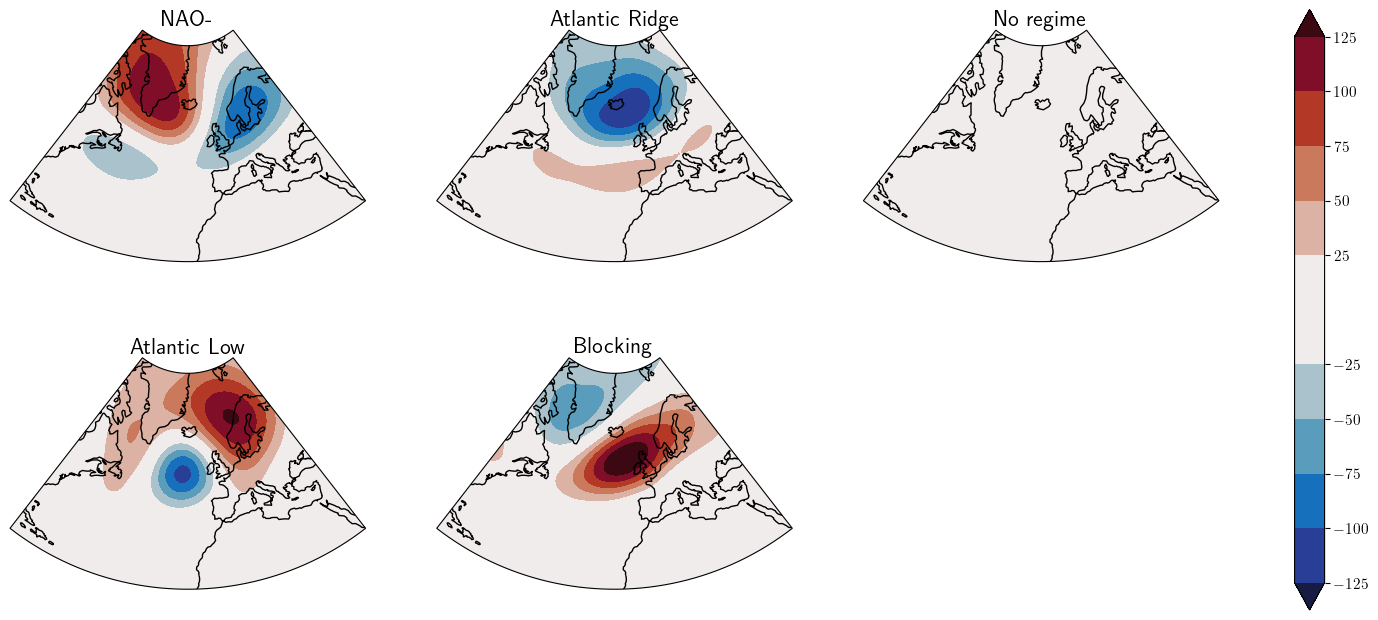

In [132]:
clu = Clusterplot(2, 3, get_region(centers_z), lambert_projection=True, numbering=False)
_ = clu.add_any_contour_from_mask(exp_z.da / 9.81, mask_updated[:, [1, 2, 0, 3, 4]], cmap=colormaps.balance, levels=11, titles=titles)
clu.axes[-1].set_visible(False)

In [133]:
s_and_z = (mask[:, :, None] & mask_updated[:, None, :])

In [134]:
titles = [
    "No regime",
    "NAO-",
    "Atlantic Ridge",
    "Atlantic Low",
    "Blocking",
]
titles = [f"{title}, (${prop * 100:.1f} \%$)" for title, prop in zip(titles, mask_updated.mean(axis=0))]

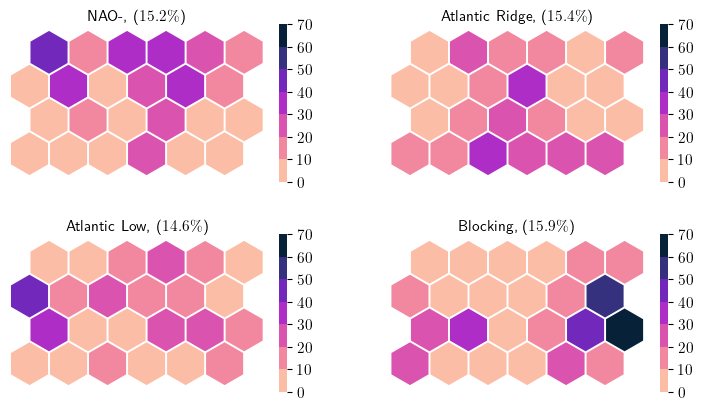

In [135]:
fig, axes = plt.subplots(2, 2, figsize=(9, 5), subplot_kw={"aspect": "equal"})
s_and_z_mean = s_and_z.mean(axis=0) / mask.mean(axis=0)[:, None]
cmap = colormaps.bubblegum_r
factor = 100
norm = BoundaryNorm(MaxNLocator(7).tick_values(s_and_z_mean.min() * factor, s_and_z_mean.max() * factor), cmap.N)
for i, ax in enumerate(axes.ravel()):
    fig, ax = net.plot_on_map(
        s_and_z_mean[:, i + 1] * factor,
        fig=fig,
        ax=ax,
        cmap=cmap,
        norm=norm,
        cbar_kwargs={"shrink": 0.9},
    )
    ax.set_title(titles[i + 1])

## Error

In [ ]:
X, da_weighted = exp_s.prepare_for_clustering()
da_weighted = coarsen_da(da_weighted, 1.5)
X = da_weighted.data.reshape(exp_s.data_handler.get_flat_shape()[0], -1)
X, meanX, stX = normalize(X)
X = compute(X, progress_flag=True)

distances = np.zeros(net.n_nodes)
for i in trange(net.n_nodes):
    w = net.weights[i].flatten()[None, :]
    mask = labels.data == i
    x = X[mask] .reshape(np.sum(mask), -1) 
    distances[i] = np.mean(pairwise_distances(x, w))

100%|██████████| 24/24 [00:00<00:00, 34.15it/s]


Text(0.5, 1.0, 'Error')

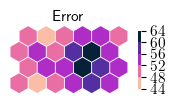

In [21]:
fig, ax = plt.subplots(figsize=(0.33 * TEXTWIDTH_IN, 1.2), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.bubblegum_r
# norm = BoundaryNorm(np.arange(7, 10, .5), cmap.N)
fig, ax = net.plot_on_map(distances, fig=fig, ax=ax, cmap=cmap, discretify=True, cmap_kwargs=dict(shrink=1.))
ax.set_title("Error")

/scratch/local/11099336/ipykernel_1494877/3356367474.py:2: RuntimeWarning: invalid value encountered in divide
  separatedness = pairwise_distances(net.weights) / net.neighborhoods.distances


Text(0.5, 1.0, 'Separatedness')

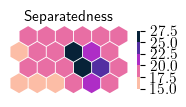

In [ ]:
from sklearn.metrics import pairwise_distances
separatedness = pairwise_distances(net.weights) / net.neighborhoods.distances
separatedness = np.nanmean(separatedness, axis=1)
fig, ax = plt.subplots(figsize=(0.33 * TEXTWIDTH_IN, 1.2), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.bubblegum_r
fig, ax = net.plot_on_map(separatedness, fig=fig, ax=ax, cmap=cmap, discretify=True, cmap_kwargs=dict(shrink=1.))
ax.set_title("Separatedness")

## Typical summer pathway

In [43]:
timestepwise = []
group = [] 
for i, (_, group_) in enumerate(labels.groupby(labels.time.dt.dayofyear).groups.items()):
    group.append(group_)
    if i % 7 != 6:
        continue
    group = np.concatenate(group)
    coords = net.neighborhoods.coordinates[labels[group]]
    unique, count = np.unique(labels[group], return_counts=True)
    
    coordsmax = coords.max(axis=0, keepdims=True)
    thetas = coords / coordsmax * 2 * np.pi
    xi, zeta = np.cos(thetas), np.sin(thetas)
    mxi, mzeta = np.mean(xi, axis=0), np.mean(zeta, axis=0)
    com = np.arctan2(-mzeta, -mxi) + np.pi
    com = com / 2 / np.pi * coordsmax
    
    maxdx = net.x
    maxdy = net.y
    dx = np.abs(coords[:, 0] - com[0, 0])
    dy = np.abs(coords[:, 1] - com[0, 1])
    mask_periodic = dx > maxdx
    dx[mask_periodic] = maxdx - dx[mask_periodic]
    mask_periodic = dy > maxdy
    dy[mask_periodic] = maxdy - dy[mask_periodic]
    stdx = np.sqrt(np.sum(dx ** 2) / (len(dx) - 1))
    stdy = np.sqrt(np.sum(dy ** 2) / (len(dy) - 1))
    variab = np.asarray([stdx, stdy])
    timestepwise.append((com.squeeze(), variab.squeeze(), unique, count))
    group = []
    
com = np.asarray([step_[0] for step_ in timestepwise])
com_std = np.asarray([step_[1] for step_ in timestepwise])

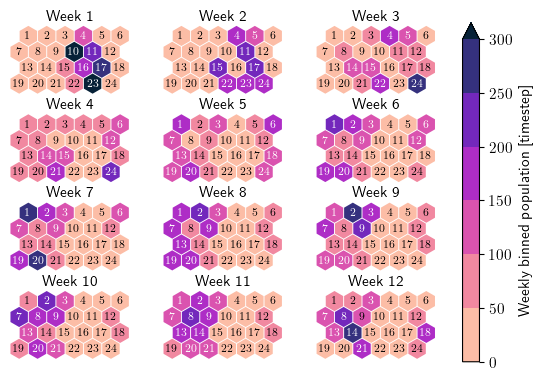

In [61]:
fig, axes = plt.subplots(4, 3, figsize=(TEXTWIDTH_IN, 4.4), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.bubblegum_r
max_ = np.quantile([np.amax(timestepwis[3]) for timestepwis in timestepwise], 0.8)
norm = BoundaryNorm(MaxNLocator(6).tick_values(0, max_), cmap.N, extend="max")
im = ScalarMappable(norm, cmap)
coords = net.neighborhoods.coordinates
cbar = fig.colorbar(im, ax=axes)
cbar.ax.set_ylabel("Weekly binned population [timestep]")
for i, ax in enumerate(axes.ravel()):
    step = i + 1
    unique, counts = timestepwise[step][2], timestepwise[step][3]
    to_plot = np.zeros(net.n_nodes)
    to_plot[unique] = counts
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
        linewidths=0,
    )
    # ax.errorbar(*com[step], *com_std[step][[1, 0]])
    ax.set_title(f"Week {step}", pad=2)
    
    for i, c in enumerate(coords):
        x, y = c
        color = "white" if to_plot[i] > 100 else "black"
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color=color, fontsize=8)
fig.set_tight_layout(False)
plt.savefig(f"{FIGURES}/som_props/weekly_pathway.png")

In [52]:
np.amax([np.amax(timestepwis[3]) for timestepwis in timestepwise]) / 4

np.float64(159.5)

In [22]:
coords = net.neighborhoods.coordinates
com_t = np.asarray(list(map(tuple, com)), dtype="f,f")
coords_t = np.asarray(list(map(tuple, coords)), dtype="f,f")

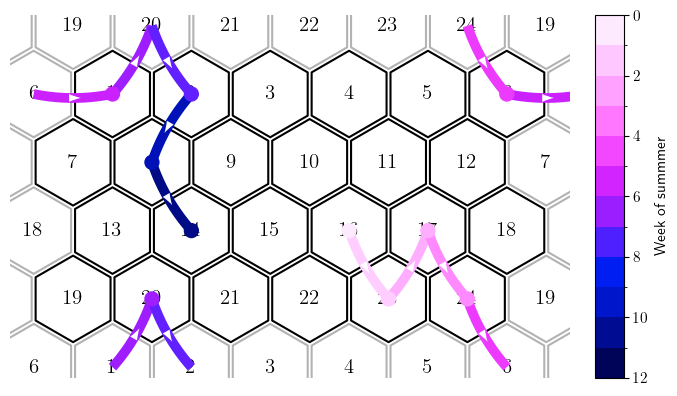

In [23]:
from xpysom_dask.plots import create_outer_grid, traj_to_segments, segments_to_arcs, plot_map
from matplotlib.collections import PatchCollection, LineCollection

outer_grid, inner_grid, coords, outermask = create_outer_grid(net.x, net.y)
edgecolors = np.full(len(coords), "black", dtype=object)
edgecolors[outermask] = "black"
alphas = np.ones(len(coords))
alphas[outermask] = 0.3

traj = []
for step_ in timestepwise:
    unique, counts = step_[2:]
    traj.append(unique[np.argmax(counts)])
traj = np.asarray(traj)   
# traj = np.argmin(pairwise_distances(com, net.neighborhoods.coordinates), axis=1) 
traj_split = np.split(traj, np.where((np.diff(traj) != 0))[0] + 1)
sizes = np.asarray([len(stay) for stay in traj_split])
uniques = np.asarray([stay[0] for stay in traj_split])
color_array = np.asarray([0, *np.cumsum(sizes)], dtype=int)
cmap = colormaps.cet_l_bmw1_r
colors = cmap(np.linspace(0, 1, len(traj) + 1))[color_array]
sort_like = np.argsort(sizes)[::-1]
    
segments, reps = traj_to_segments(traj_split, coords, outer_grid, outermask)
arcs, arrows = segments_to_arcs(segments)

gs = plt.GridSpec(
    1,
    3,
    width_ratios=[1, 0.02, 0.05],
    wspace=0.01,
    left=0.01,
    right=0.9,
    bottom=0.01,
    top=0.99,
)
fig = plt.figure(figsize=(TEXTWIDTH_IN, 3.7))
ax = fig.add_subplot(gs[0], aspect="equal")
ax_cbar = fig.add_subplot(gs[2])
inner_coords = coords[~outermask]
xlims = [
    np.amin(inner_coords[:, 0]) - 0.8,
    np.amax(inner_coords[:, 0]) + 0.8,
]
ylims = [
    np.amin(inner_coords[:, 1]) - 1,
    np.amax(inner_coords[:, 1]) + 1,
]

fig, ax = plot_map(
    coords,
    np.zeros(len(coords)) + np.nan,
    "hexagons",
    draw_cbar=False,
    show=False,
    edgecolors=edgecolors,
    alphas=alphas,
    linewidths=1.5,
    fig=fig,
    ax=ax,
)
for i, c in enumerate(coords):
    x, y = c
    if x > xlims[0] and x < xlims[-1] and y > ylims[0] and y < ylims[-1]: 
        ax.text(x, y, f'${outer_grid.flatten()[i] + 1}$', va='center', ha='center', color="black", fontsize=15)
lc = LineCollection(arcs, colors=np.repeat(colors[1:-1], reps, axis=0), zorder=3)
lc.set_linewidth(7)
lc = ax.add_collection(lc)
arrows = PatchCollection(arrows, zorder=9, edgecolor=None, facecolor="white")
ax.add_collection(arrows)
im = ScalarMappable(BoundaryNorm(np.arange(0, len(traj)), cmap.N), cmap)
cbar = fig.colorbar(
    im,
    cax=ax_cbar,
    label="Week of summmer"
)
uniques = uniques[sort_like]
sizes = sizes[sort_like]
colors = colors[:-1][sort_like]
ax.scatter(*coords[~outermask][uniques].T, s=100, c=colors, zorder=10)
colors = cmap(np.linspace(0, 1, len(com)))
# for color, com_, com_std_ in zip(colors, com, com_std):
#     com_ = com_ + np.asarray([ 4., 3.4641 ])
#     ax.errorbar(*com_, *com_std_[[1, 0]], zorder=10, color=color)
ax_cbar.invert_yaxis()
ax.set_xlim(xlims)
ax.set_ylim(ylims)
plt.savefig(f"{FIGURES}/som_props/track_com.png")

## DST

In [ ]:
from CDSK import dynamical_local_indexes
X, da = exp_s.prepare_for_clustering()
X = exp_s.pca_transform(X, 100)
ld, theta, alpha = dynamical_local_indexes(X, n_jobs=10)
np.save(exp_s.path.joinpath("ld_100"), ld.squeeze())
np.save(exp_s.path.joinpath("theta_100"), theta.squeeze())

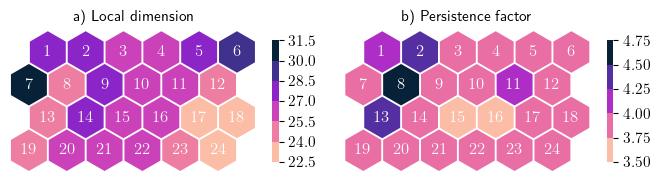

In [45]:
ld = np.load(exp_s.path.joinpath("ld_100.npy"))
theta = np.load(exp_s.path.joinpath("theta_100.npy"))

to_plot_ld = timeseries_on_map(ld, net.bmus)[0]
to_plot_theta = timeseries_on_map(1 / theta, net.bmus)[0]

cmap = colormaps.bubblegum_r
fig, axes = plt.subplots(1, 2, figsize=(1. * TEXTWIDTH_IN, 2), tight_layout=False, subplot_kw=dict(aspect="equal"))
fig, axes[0] = net.plot_on_map(
    to_plot_ld,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    discretify=True,
)
axes[0].set_title("a) Local dimension")
fig, axes[1] = net.plot_on_map(
    to_plot_theta,
    smooth_sigma=0,
    fig=fig,
    cmap=cmap,
    ax=axes[1],
    discretify=True,
)
axes[1].set_title("b) Persistence factor")
coords = net.neighborhoods.coordinates
for i, c in enumerate(coords):
    x, y = c
    for ax in axes:
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color="white", fontsize=10)
fig.savefig(f'{FIGURES}/som_props/DST.png')

## pops, stats

In [39]:
from scipy.stats import linregress
da = exp_s.da
df = pd.read_csv(f"{DATADIR}/ERA5/daily_nao.csv", delimiter=",")
index = pd.to_datetime(df.iloc[:, :3])
series = xr.DataArray(df.iloc[:, 3].values, coords={"time": index})
nao_summer = series.interp_like(da)
nao_on_map = timeseries_on_map(nao_summer, net.latest_bmus)[0]

yearly = mask_da.resample(time="1YE").sum().values
trends = np.zeros(net.n_nodes)
pvalues = trends.copy()
for k, yearly_ in enumerate(yearly.T):
    trends[k], _, _, pvalues[k], _ = linregress(
        np.arange(yearly.shape[0])[yearly_ != 0], yearly_[yearly_ != 0]
    )


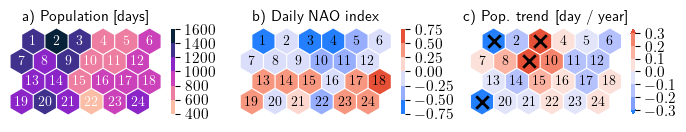

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.46), tight_layout=True, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
cmap = colormaps.bubblegum_r
fig, axes[0] = net.plot_on_map(
    populations,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    discretify=True,
    linewidths=0,
)
axes[0].set_title("a) Population [days]", pad=2)
cmap = colormaps.cet_d_bwr
fig, axes[2] = net.plot_on_map(
    trends,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    norm=BoundaryNorm(np.linspace(-0.3, 0.3, 7), cmap.N, extend="both"),
    fig=fig,
    ax=axes[2],
    linewidths=0,
)
coords = net.neighborhoods.coordinates
where_signif = np.where(pvalues < 0.05)[0]
signif = net.neighborhoods.coordinates[where_signif]
# axes[2].scatter(*coords.T, s=260, edgecolors="black", marker="h", linewidths=1., facecolors="none")
axes[2].scatter(*signif.T, s=80, c="black", marker="x", linewidths=2.)
axes[2].set_title("c) Pop. trend [day / year]", pad=2)
fig, axes[1] = net.plot_on_map(
    nao_on_map,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[1],
    cmap=cmap,
    # discretify=True,
    norm=BoundaryNorm(np.linspace(-0.75, 0.75, 7), cmap.N),
    linewidths=0,
)
axes[1].set_title("b) Daily NAO index", pad=2)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        color = "white" if j == 0 else "black"
        if j == 2 and i in where_signif:
            continue
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color=color, fontsize=10)
fig.savefig(f'{FIGURES}/som_props/pop_nao_trend.png')

In [68]:
yearly_pops = xarray_to_polars(labels)
yearly_pops = yearly_pops.group_by(pl.col("time").dt.year().alias("year"), pl.col("labels"), maintain_order=True).len()
indexer = yearly_pops[["year"]].unique().join(yearly_pops[["labels"]].unique(), how="cross")
yearly_pops = indexer.join(yearly_pops, how="left", on=["year", "labels"]).fill_null(0).sort("year", "labels")

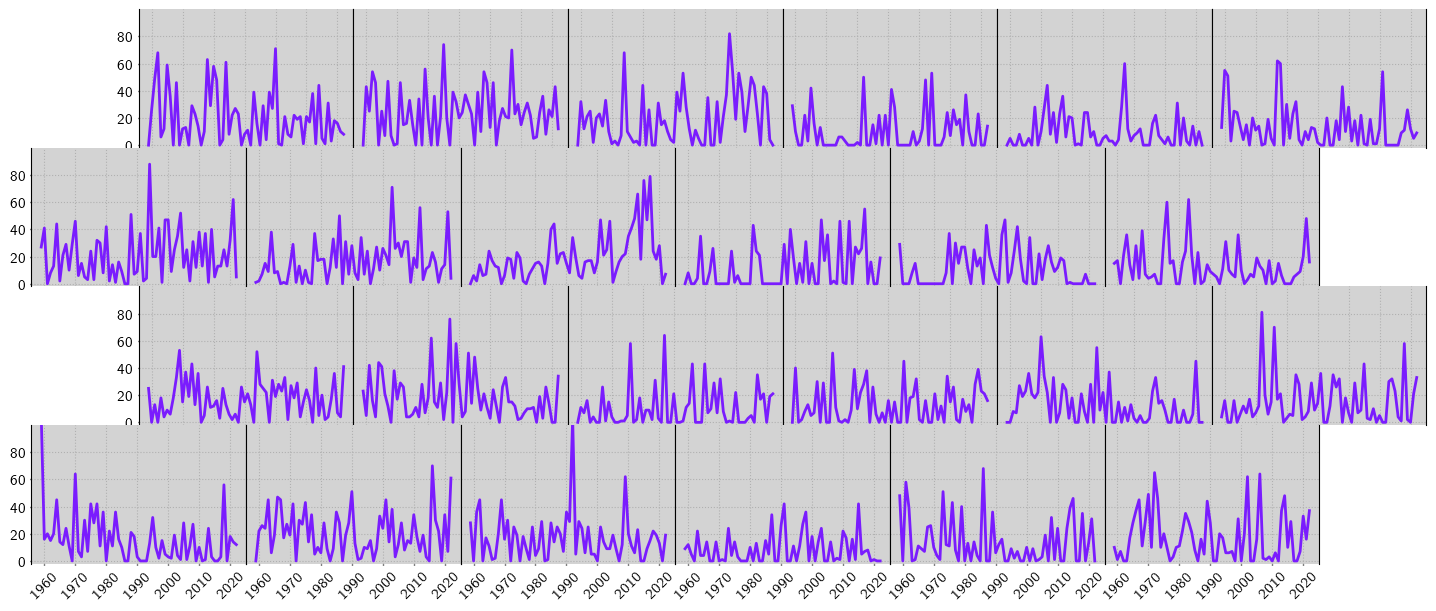

In [127]:
fig, axes = honeycomb_panel(
    4, 6, .4
)
year_ticks = [1960, 1970, 1980, 1990, 2000, 2010, 2020]
pop_ticks = [0, 20, 40, 60, 80]
for (l, ax), (i, j) in zip(enumerate(axes.ravel()), zip(*np.unravel_index(np.arange(axes.size), axes.shape))):
    ax.spines[["top", "bottom"]].set_visible(False)
    this_pop = yearly_pops.filter(pl.col("labels") == l)
    ax.plot(this_pop["year"], this_pop["len"], color=COLORS[1], lw=2)
    ax.grid(linestyle="dotted")
    ax.set_ylim([-2, 100])
    ax.set_facecolor('lightgray')
    if i == 3:
        ax.set_xticks(year_ticks, labels=year_ticks, rotation=45)
        ax.tick_params(axis='x', width=1, size=1)
    else:
        ax.set_xticks(year_ticks, labels=[])
        ax.tick_params(axis='x', width=0, size=0)
    if j == 0:
        ax.set_yticks(pop_ticks, labels=pop_ticks)
        ax.tick_params(axis='y', width=1, size=1)
    else:       
        ax.set_yticks(pop_ticks, labels=[])
        ax.tick_params(axis='y', width=0, size=0)

## PVs

In [39]:
from jetstream_hugo.definitions import _compute
da_pvs = Experiment(DataHandler.from_specs("ERA5", "surf", "pvs", "6H", "all", "JJA", *get_region(da), 250, "hourofyear", {"hourofyear": ("win", 60)})).da
da_pvs = _compute(da_pvs, progress=True)


[########################################] | 100.00% Completed | 2.95 sms


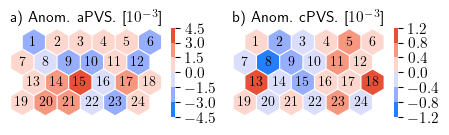

In [41]:
time_mask = np.isin(labels.time.values, da_pvs.time.values)
to_plot_anti = np.asarray([da_pvs.loc[:, 'anti'][mask_[time_mask]].mean().item() for mask_ in mask.T])
to_plot_cycl = np.asarray([da_pvs.loc[:, 'cycl'][mask_[time_mask]].mean().item() for mask_ in mask.T])

fig, axes = plt.subplots(1, 2, figsize=(0.66 * TEXTWIDTH_IN, 1.5), tight_layout=True, subplot_kw=dict(aspect="equal"))
fig, axes[0] = net.plot_on_map(
    to_plot_anti * 1000,
    smooth_sigma=0,
    show=False,
    cmap=colormaps.cet_d_bwr,
    fig=fig,
    ax=axes[0],
    discretify=True,
)
axes[0].set_title(r"a) Anom. aPVS. [$10^{-3}$]", pad=2)
fig, axes[1] = net.plot_on_map(
    to_plot_cycl * 1000,
    smooth_sigma=0,
    fig=fig,
    cmap=colormaps.cet_d_bwr,
    ax=axes[1],
    discretify=True,
)
axes[1].set_title(r"b) Anom. cPVS. [$10^{-3}$]", pad=2)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color="black", fontsize=10)
fig.savefig(f'{FIGURES}/som_props/PVS_activity.png')

## rt, $\sigma=0$

In [30]:
yearbreak = np.sum(labels.time.dt.year.values == 1999)
mean_res, max_res, trend_res, pvalues = net.compute_residence_time(smooth_sigma=0, yearbreaks=yearbreak, q=0.95)

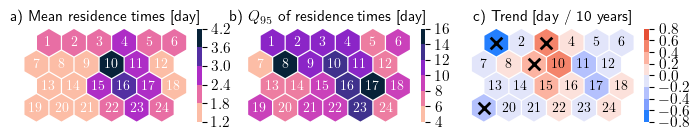

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.55), tight_layout=True, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
cmap = colormaps.bubblegum_r
fig, axes[0] = net.plot_on_map(
    mean_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    discretify=True,
)
axes[0].set_title("a) Mean residence times [day]")
fig, axes[1] = net.plot_on_map(
    max_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[1],
    discretify=True,
)
axes[1].set_title("b) $Q_{95}$ of residence times [day]")
fig, axes[2] = net.plot_on_map(
    trend_res / 4 * 10,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[2],
    cmap=colormaps.cet_d_bwr,
    discretify=True,
)
axes[2].set_title("c) Trend [day / 10 years]")
where_signif = np.where(pvalues < 0.05)[0]
signif = net.neighborhoods.coordinates[where_signif]
axes[2].scatter(*signif.T, s=70, c="black", marker="x", linewidths=2)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        color = "white" if j < 2 else "black"
        if j == 2 and i in where_signif:
            continue
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color=color, fontsize=10)
fig.savefig(f'{FIGURES}/som_props/residence.png')

## rt, $\sigma=1$

In [41]:
yearbreak = np.sum(labels.time.dt.year.values == 1999)
mean_res, max_res, trend_res, pvalues = net.compute_residence_time(smooth_sigma=0, yearbreaks=yearbreak, q=0.95)

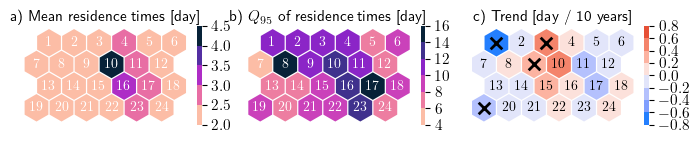

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.55), tight_layout=True, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
fig, axes[0] = net.plot_on_map(
    mean_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    norm=BoundaryNorm(np.linspace(2, 4.5, 6), cmap.N, extend="neither"),
    # discretify=True,
    cbar_kwargs=dict(shrink=0.85, spacing="proportional")
)
axes[0].set_title("a) Mean residence times [day]")
fig, axes[1] = net.plot_on_map(
    max_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[1],
    discretify=True,
    cbar_kwargs=dict(shrink=0.85)
)
axes[1].set_title("b) $Q_{95}$ of residence times [day]")
fig, axes[2] = net.plot_on_map(
    trend_res / 4 * 10,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[2],
    cmap=colormaps.cet_d_bwr,
    discretify=True,
    cbar_kwargs=dict(shrink=0.85)
)
axes[2].set_title("c) Trend [day / 10 years]")
where_signif = np.where(pvalues < 0.05)[0]
signif = net.neighborhoods.coordinates[where_signif]
axes[2].scatter(*signif.T, s=70, c="black", marker="x", linewidths=2)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        color = "white" if j < 2 else "black"
        if j == 2 and i in where_signif:
            continue
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color=color, fontsize=10)
fig.savefig(f'{FIGURES}/som_props/residence_sigma1.png')

## rt, real $\sigma=0.1$

In [48]:
yearbreak = np.sum(labels.time.dt.year.values == 1999)
mean_res, max_res, trend_res, pvalues, all_lengths = net.compute_residence_time_real_sigma(smooth_sigma_quantile=0.1, yearbreaks=yearbreak, q=0.95)

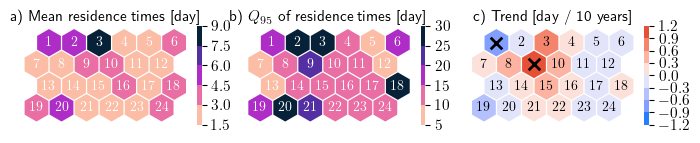

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.55), tight_layout=True, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
fig, axes[0] = net.plot_on_map(
    mean_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    # norm=BoundaryNorm(np.linspace(2, 6.5, 8), cmap.N, extend="neither"),
    discretify=True,
    cbar_kwargs=dict(shrink=0.85, spacing="proportional")
)
axes[0].set_title("a) Mean residence times [day]")
fig, axes[1] = net.plot_on_map(
    max_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[1],
    discretify=True,
    cbar_kwargs=dict(shrink=0.85)
)
axes[1].set_title("b) $Q_{95}$ of residence times [day]")
fig, axes[2] = net.plot_on_map(
    trend_res / 4 * 10,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[2],
    cmap=colormaps.cet_d_bwr,
    discretify=True,
    cbar_kwargs=dict(shrink=0.85)
)
axes[2].set_title("c) Trend [day / 10 years]")
where_signif = np.where(pvalues < 0.05)[0]
signif = net.neighborhoods.coordinates[where_signif]
axes[2].scatter(*signif.T, s=70, c="black", marker="x", linewidths=2)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        color = "white" if j < 2 else "black"
        if j == 2 and i in where_signif:
            continue
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color=color, fontsize=10)
fig.savefig(f'{FIGURES}/som_props/residence_real_sigma0.1.png')

## new rt

In [31]:
from xpysom_dask.diagnostics import *
from sklearn.metrics import pairwise_distances
distances = pairwise_distances(net.weights)
sigma = np.quantile(distances[distances > 0], 0.1)
spells = get_persistent_spell_times_from_som(labels, dists=distances, sigma=sigma, nt_before=0, minlen=16, nojune=False)

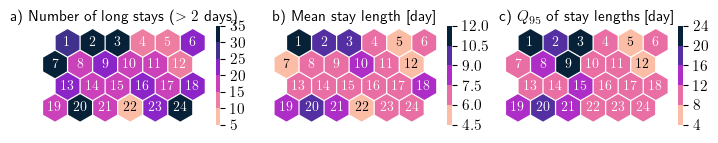

In [38]:
spells_per_cluster = spells.filter(pl.col("relative_index") == 0).group_by("value").len()
spells_per_cluster = pl.Series("value", np.arange(24)).to_frame().join(spells_per_cluster, how="left", on="value").fill_null(0)
cmap = colormaps.bubblegum_r
n_stays = spells_per_cluster["len"].to_numpy()

len_per_cluster = spells.group_by("value").len()
len_per_cluster = pl.Series("value", np.arange(24)).to_frame().join(len_per_cluster, how="left", on="value").fill_null(0)
len_per_cluster = len_per_cluster.with_columns(pl.col("len") / spells_per_cluster["len"])
mean_len = len_per_cluster["len"].to_numpy() / 4

max_len_per_cluster = spells.group_by(["value", "spell"]).len().group_by("value").agg(pl.col("len").quantile(0.95))
max_len_per_cluster = pl.Series("value", np.arange(24)).to_frame().join(max_len_per_cluster, how="left", on="value")
max_len = max_len_per_cluster["len"].to_numpy() / 4

fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.55), tight_layout=True, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
cmap = colormaps.bubblegum_r
fig, axes[0] = net.plot_on_map(
    n_stays,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    numbering=True,
    fig=fig,
    ax=axes[0],
    discretify=True,
    cbar_kwargs=dict(shrink=0.85)
)
axes[0].set_title("a) Number of long stays ($> 2$ days)")
fig, axes[1] = net.plot_on_map(
    mean_len,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    numbering=True,
    fig=fig,
    ax=axes[1],
    discretify=True,
    cbar_kwargs=dict(shrink=0.85)
)
axes[1].set_title("b) Mean stay length [day]")
    
fig, axes[2] = net.plot_on_map(
    max_len,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    numbering=True,
    fig=fig,
    ax=axes[2],
    discretify=True,
    cbar_kwargs=dict(shrink=0.85)
)
axes[2].set_title("c) $Q_{95}$ of stay lengths [day]")
    
fig.savefig(f'{FIGURES}/som_props/residence_new.png')

## lots of line plots

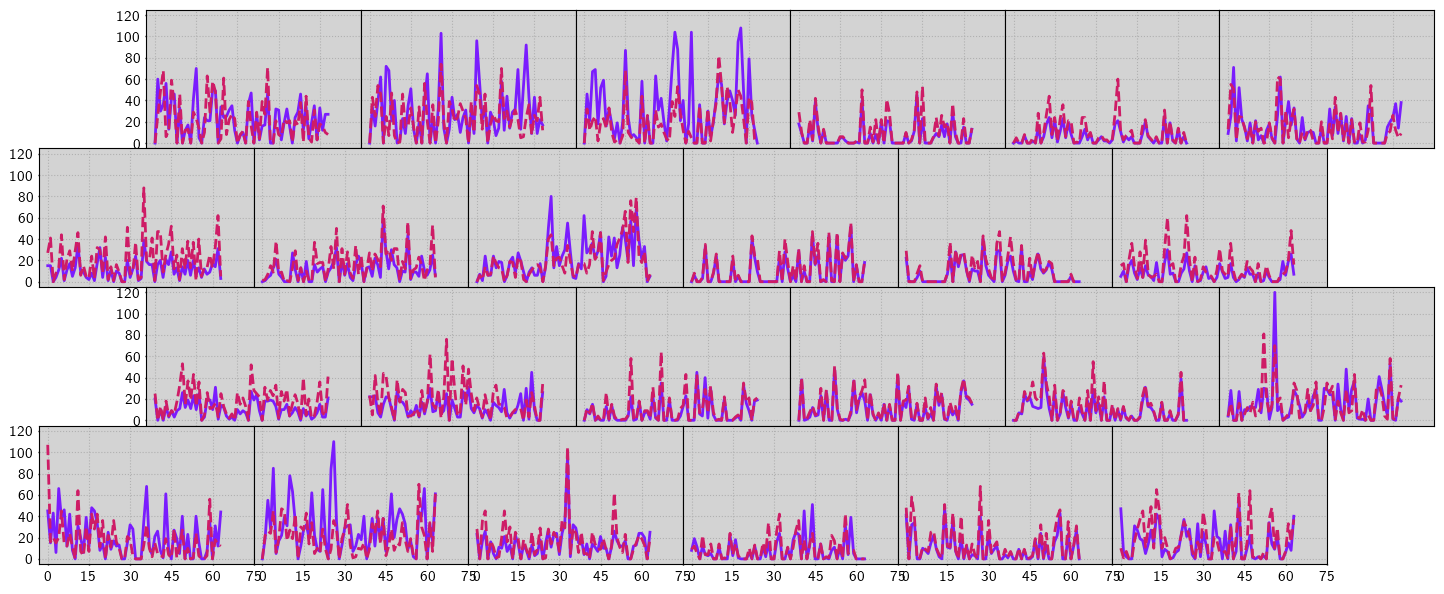

In [168]:
yearly_pops = xarray_to_polars(labels)
yearly_pops = yearly_pops.group_by(pl.col("time").dt.year().alias("year"), pl.col("labels"), maintain_order=True).len()
indexer = yearly_pops[["year"]].unique().join(yearly_pops[["labels"]].unique(), how="cross")
yearly_pops = indexer.join(yearly_pops, how="left", on=["year", "labels"]).fill_null(0).sort("year", "labels")
res_each_year = np.zeros((24, 64), dtype=np.float32)
for i in range(24):
    for j, lens_ in enumerate(all_lengths[i]):
        res_each_year[i, j] = np.nanquantile(lens_, 0.95)
res_each_year = np.nan_to_num(res_each_year, 0).astype(np.int32)
yearly_pops = yearly_pops.with_columns(res=res_each_year.flatten(order="F"))
decadal_pop = yearly_pops.group_by((pl.col("year").rle_id() // 1).rle_id().alias("decade"), pl.col("labels"), maintain_order=True).mean()
fig, axes = honeycomb_panel(
    4, 6, .4
)
ylims = [decadal_pop["res"].min(), decadal_pop["res"].max()]
decades_ticks = MaxNLocator(6).tick_values(*decadal_pop["decade"][[0, -1]]).astype(np.int32)
pop_ticks = MaxNLocator(6).tick_values(*ylims).astype(np.int32)
for (l, ax), (i, j) in zip(enumerate(axes.ravel()), zip(*np.unravel_index(np.arange(axes.size), axes.shape))):
    this_pop = decadal_pop.filter(pl.col("labels") == l)
    ax.plot(this_pop["decade"], this_pop["res"], color=COLORS[1], lw=2)
    ax.plot(this_pop["decade"], this_pop["len"], color=COLORS[3], lw=2, ls="dashed")
    ax.grid(linestyle="dotted")
    ax.set_facecolor('lightgray')
    ax.set_ylim(ylims[0] - 5, pop_ticks[-1] + 5)
    if i == 3:
        ax.set_xticks(decades_ticks, labels=decades_ticks, rotation=0)
        ax.tick_params(axis='x', width=1, size=1)
    else:
        ax.set_xticks(decades_ticks, labels=[])
        ax.tick_params(axis='x', width=0, size=0)
    if j == 0:
        ax.set_yticks(pop_ticks, labels=pop_ticks)
        ax.tick_params(axis='y', width=1, size=1)
    else:       
        ax.set_yticks(pop_ticks, labels=[])
        ax.tick_params(axis='y', width=0, size=0)
# year_ticks = [1960, 1970, 1980, 1990, 2000, 2010, 2020]
# pop_ticks = [0, 20, 40, 60, 80, 100]
# for (l, ax), (i, j) in zip(enumerate(axes.ravel()), zip(*np.unravel_index(np.arange(axes.size), axes.shape))):
#     this_pop = yearly_pops.filter(pl.col("labels") == l)
#     ax.plot(this_pop["year"], this_pop["res"], color=COLORS[1], lw=2)
#     ax.plot(this_pop["year"], this_pop["len"], color=COLORS[3], lw=2, ls="dashed")
#     ax.grid(linestyle="dotted")
#     ax.set_ylim([-10, 120])
#     ax.set_facecolor('lightgray')
#     if i == 3:
#         ax.set_xticks(year_ticks, labels=year_ticks, rotation=45)
#         ax.tick_params(axis='x', width=1, size=1)
#     else:
#         ax.set_xticks(year_ticks, labels=[])
#         ax.tick_params(axis='x', width=0, size=0)
#     if j == 0:
#         ax.set_yticks(pop_ticks, labels=pop_ticks)
#         ax.tick_params(axis='y', width=1, size=1)
#     else:       
#         ax.set_yticks(pop_ticks, labels=[])
#         ax.tick_params(axis='y', width=0, size=0)

In [ ]:
decadal_pop

decade,labels,year,len,res
u32,i64,f64,f64,f64
0,0,1963.5,30.2,31.7
0,1,1963.5,25.4,35.2
0,2,1963.5,18.2,38.0
0,3,1963.5,13.5,10.9
0,4,1963.5,4.6,2.6
…,…,…,…,…
6,19,2020.5,25.5,27.5
6,20,2020.5,12.75,17.25
6,21,2020.5,0.25,0.0


## lagged backwards diffusion

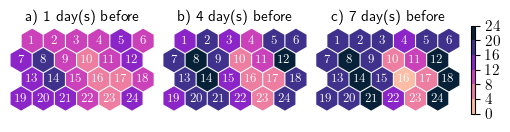

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.), gridspec_kw=dict(wspace=0.06, hspace=0.02, bottom=0.00, top=0.98), tight_layout=False, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
norm = BoundaryNorm(np.arange(0, net.n_nodes + 4, 4), cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, pad=0.02, shrink=0.9)
steps = [4, 16, 28]
for step, ax, letter in zip(steps, axes, ["a", "b", "c"]):
    transmat = net.compute_transmat(step=step, yearbreaks=yearbreak)
    dilution = np.sum(transmat > 0.01, axis=0)
    fig, ax = net.plot_on_map(
        dilution,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    ) 
    ax.set_title(f"{letter}) {step // 4} day(s) before", pad=2)
fig.set_tight_layout(False)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color="white", fontsize=9)
fig.savefig(f'{FIGURES}/som_props/dilution_before.png')

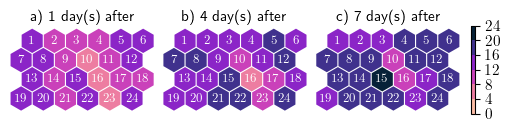

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.), gridspec_kw=dict(wspace=0.06, hspace=0.02, bottom=0.00, top=0.98), tight_layout=False, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
norm = BoundaryNorm(np.arange(0, net.n_nodes + 4, 4), cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, pad=0.02, shrink=0.9)
steps = [4, 16, 28]
for step, ax, letter in zip(steps, axes, ["a", "b", "c"]):
    transmat = net.compute_transmat(step=step, yearbreaks=yearbreak)
    dilution = np.sum(transmat > 0.01, axis=1)
    fig, ax = net.plot_on_map(
        dilution,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    ) 
    ax.set_title(f"{letter}) {step // 4} day(s) after", pad=2)
fig.set_tight_layout(False)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color="white", fontsize=9)
fig.savefig(f'{FIGURES}/som_props/dilution_after.png')

## lagged backwards transitions

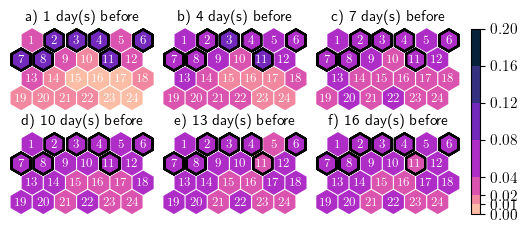

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(TEXTWIDTH_IN, 2.1), gridspec_kw=dict(wspace=0.06, hspace=0.02, bottom=0.00, top=0.98), tight_layout=False, subplot_kw=dict(aspect="equal"))
norm = BoundaryNorm([0, 0.01, 0.02, 0.04, 0.08, 0.12, 0.16, 0.2], cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, spacing="proportional", shrink=0.9, pad=0.02)
to_ = [1, 2, 3, 5, 6, 7, 10]
coords = net.neighborhoods.coordinates
coords_subset = net.neighborhoods.coordinates[to_]
for i, (ax, letter) in enumerate(zip(axes.ravel(), list("abcdef"))):
    step = 4 + 12 * i
    transmat = np.mean(net.compute_transmat(step=step, yearbreaks=yearbreak)[:, to_], axis=1)
    fig, ax = net.plot_on_map(
        transmat,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    for j in to_:
        ax.scatter(*coords_subset.T, s=250, edgecolors="black", marker="h", linewidths=1.5, facecolors="none")
    ax.set_title(f"{letter}) {step // 4} day(s) before", pad=2)
fig.set_tight_layout(False)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes.ravel()):
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color="white", fontsize=9)
plt.savefig(f'{FIGURES}/som_props/lagged_transition_subspace.png')

## Back and forward mean distance

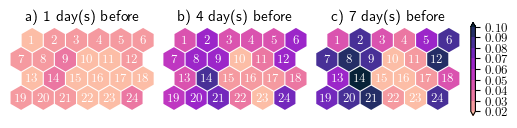

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.), gridspec_kw=dict(wspace=0.06, hspace=0.02, bottom=0.00, top=0.98), tight_layout=False, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
cmap = colormaps.bubblegum_r
norm = BoundaryNorm(np.arange(0.02, 0.11, 0.01), cmap.N, extend="both")
im = ScalarMappable(norm, cmap)
cbar = fig.colorbar(im, ax=axes, pad=0.02, shrink=0.95)
cbar.ax.tick_params(labelsize=9)
steps = [4, 16, 28]
dists = net.neighborhoods.distances
for step, ax, letter in zip(steps, axes, list("abc")):
    transmat = net.compute_transmat(step=step, yearbreaks=yearbreak)
    mean_dists = np.zeros(net.n_nodes)
    for node, col in enumerate(transmat.T):
        mean_dists[node] = np.mean(col * dists[node])
    
    fig, ax = net.plot_on_map(
        mean_dists,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    ) 
    ax.set_title(f"{letter}) {step // 4} day(s) before", pad=2)
fig.set_tight_layout(False)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes.ravel()):
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color="white", fontsize=9)
fig.savefig(f'{FIGURES}/som_props/distance_dilution_before.png')

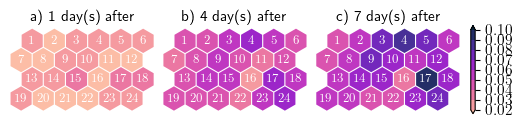

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.), gridspec_kw=dict(wspace=0.06, hspace=0.02, bottom=0.00, top=0.98), tight_layout=False, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
norm = BoundaryNorm(np.arange(0.02, 0.11, 0.01), cmap.N, extend="both")
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, pad=0.02, shrink=0.9)
steps = [4, 16, 28]
dists = net.neighborhoods.distances
for step, ax, letter in zip(steps, axes, list("abc")):
    transmat = net.compute_transmat(step=step, yearbreaks=yearbreak)
    mean_dists = np.zeros(net.n_nodes)
    for node, line in enumerate(transmat):
        mean_dists[node] = np.mean(line * dists[node])
    
    fig, ax = net.plot_on_map(
        mean_dists,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    ) 
    ax.set_title(f"{letter}) {step // 4} day(s) after", pad=2)
fig.set_tight_layout(False)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes.ravel()):
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color="white", fontsize=9)
fig.savefig(f'{FIGURES}/som_props/distance_dilution_after.png')

## jet indices

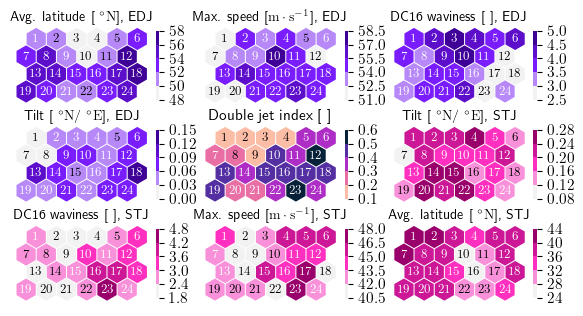

In [43]:
data_vars_and_jets = [
    ("mean_lat", "EDJ"),
    ("s_star", "EDJ"),
    ("wavinessDC16", "EDJ"),
    ("tilt", "EDJ"),
    ("double_jet_index", "STJ"),
    ("tilt", "STJ"),
    ("wavinessDC16", "STJ"),
    ("s_star", "STJ"),
    ("mean_lat", "STJ"),
]
fig, axes = plt.subplots(3, 3, figsize=(TEXTWIDTH_IN, 2.9), gridspec_kw=dict(wspace=0.15, hspace=0.15, bottom=0.00, top=0.98), sharex="all", subplot_kw=dict(aspect="equal"))
axes = axes.flatten()
for (varname, jet), (j, ax) in zip(data_vars_and_jets, enumerate(axes)):
    to_plot = props_as_df_summer.filter(pl.col("jet") == jet)[varname]
    if varname == "double_jet_index":
        cmap = colormaps.bubblegum_r
        ax.set_title(f"{PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]", pad=2)
    else:
        cmap = MYPURPLES if jet == "EDJ" else MYPINKS
        ax.set_title(f"{PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}], {jet}", pad=2, fontsize=10)
    to_plot = timeseries_on_map(to_plot, net.latest_bmus)[0]
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        fig=fig,
        ax=ax,
        draw_cbar=True,
        cmap=cmap,
        discretify=True,
        linewidths=0,
        cbar_kwargs=dict(shrink=0.8)
    )
    norm = BoundaryNorm(MaxNLocator(7).tick_values(np.amin(to_plot), np.amax(to_plot)), cmap.N)
    for i, c in enumerate(coords):
        darkness = norm(to_plot[i]) / cmap.N
        x, y = c
        # color = "white" if j == 4 else "black"
        color = "white" if darkness > 0.3 else "black"
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color=color, fontsize=9)
fig.savefig(f'{FIGURES}/som_props/combined_indices.png')